In [ ]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

from tqdm import tqdm
import pickle
import h5py

from astropy import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import healpy as hp
from astropy.io import fits
import jax.numpy as jnp

from config import config_dict, intermediates_dir
from aatw.units_constants import *
from aatw.nfw import rho_integral, rho_integral_ref
from aatw.spectral import dnu, prefac
from aatw.map_utils import pad_mbl, interp2d_vmap

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file("../matplotlibrc")

In [ ]:
ra_s  = np.linspace(0.01, 2*np.pi, 300)
dec_s = np.linspace(np.deg2rad(20), np.pi/2, 300)
ra_grid, dec_grid = np.meshgrid(ra_s, dec_s)
radec_flat = np.stack([ra_grid.ravel(), dec_grid.ravel()], axis=-1)
radec_shape = (len(dec_s), len(ra_s))

coord_grid = SkyCoord(ra=ra_grid*u.rad, dec=dec_grid*u.rad, frame='icrs')
l_grid = np.array(coord_grid.galactic.l.rad)
b_grid = np.array(coord_grid.galactic.b.rad)

l_grid = np.where(l_grid > np.pi, l_grid-2*np.pi, l_grid)
bl_flat = np.stack([b_grid.ravel(), l_grid.ravel()], axis=-1)

In [77]:
with h5py.File("../outputs/gsr/Tf_408MHz_fieldJF.h5", 'r') as hf:
    pm, pb, pl = pad_mbl(hf['Tf'][:], hf['b_s'][:], hf['l_s'][:])

In [78]:
sig_flat = interp2d_vmap(pm, pb, pl, bl_flat)
sig = sig_flat.reshape(radec_shape)

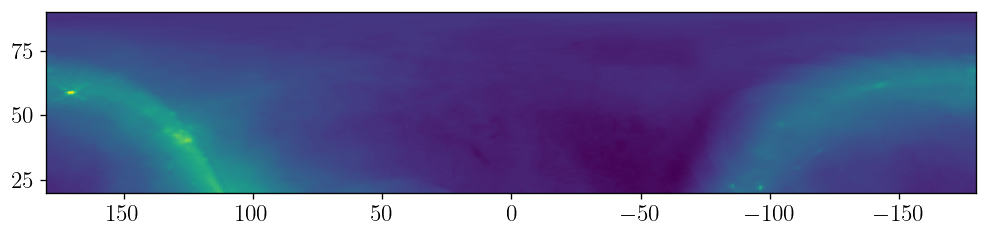

In [80]:
fig, ax = plt.subplots(figsize=(10., 5))
ax.imshow(np.flip(np.log(sig)), extent=(180, -180, 20, 90));